### Import Dependencies and Load the data

In [155]:
import os
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [156]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline,make_pipeline

In [157]:
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [158]:
path_hour = None
for root, dirs, filename in os.walk(os.getcwd()): 
    for file in filename:
        if file == 'hour_new.csv':
            path_hour = os.path.join(root, file)
            

In [159]:
df = pd.read_csv(path_hour)

### Feature Engineering

In [160]:
df.head(3)

,Unnamed: 0,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,1,2011-01-01,springer,2011,January,0,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,1,2,2011-01-01,springer,2011,January,1,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
2,2,3,2011-01-01,springer,2011,January,2,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32


In [161]:
df.columns

Index(['Unnamed: 0', 'instant', 'dteday', 'season', 'yr', 'mnth', 'hr',
       'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'cnt'],
      dtype='object')

In [162]:
df = df.drop(columns=['Unnamed: 0', 'instant', 'dteday'])
df.head(4)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,springer,2011,January,0,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,springer,2011,January,1,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
2,springer,2011,January,2,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
3,springer,2011,January,3,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13


In [163]:
cat_features = [x for x in df.columns if df[x].nunique() <= 25]
num_features = [x for x in df.columns if x not in cat_features]

In [164]:
cat_features

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit']

**Encoding Categorical Features**

In [165]:
[f"{x}:{df.columns.get_loc(x)}" for x in df]

['season:0',
 'yr:1',
 'mnth:2',
 'hr:3',
 'holiday:4',
 'weekday:5',
 'workingday:6',
 'weathersit:7',
 'temp:8',
 'atemp:9',
 'hum:10',
 'windspeed:11',
 'casual:12',
 'registered:13',
 'cnt:14']

In [166]:
nominal_cols = ['holiday', 'weathersit', 'workingday']
ordinal_cols = ['season', 'mnth', 'weekday']
ordinal_categories = [['springer', 'summer', 'fall', 'winter'],
                      ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
                      [ 'Sunday', 'Monday', 'Tueday', 'Wednesday', 'Thursday', 'Friday','Saturday']]
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed']


In [167]:
trf1 = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(sparse_output=False, drop='first'), nominal_cols),
    ('order', OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
    #('log', FunctionTransformer(func=np.log1p),['windspeed']),
    #('scale', StandardScaler(), numerical_cols)
],remainder='passthrough')

In [168]:
X = df.drop(columns=['casual','registered','cnt'])
y = df['cnt']

In [169]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [170]:
X_train = trf1.fit_transform(X_train)
X_test = trf1.fit_transform(X_test)

In [171]:
def evaluate_score(true, prediction):
    mae = mean_absolute_error(true, prediction)
    mse = mean_squared_error(true, prediction)
    rmse = root_mean_squared_error(true, prediction)
    r2score = r2_score(true, prediction)
    return r2score, mae, mse, rmse

In [172]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_train = []
r2_test = []

for i in range(len(list(models))): 
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    # Prediction 
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2, train_mae, train_mse, train_rmse = evaluate_score(y_train, y_train_pred)

    test_r2, test_mae, test_mse, test_rmse = evaluate_score(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    print('Model performance for Training set')
    print("- Mean Squared Error: {:.4f}".format(train_mse))
    print("- Root Mean Squared Error: {:.4f}".format(train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(train_mae))
    print("- R2 Score: {:.4f}".format(train_r2))
    print('-'*35)
    
    print('Model performance for Test set')
    print("- Mean Squared Error: {:.4f}".format(test_mse))
    print("- Root Mean Squared Error: {:.4f}".format(test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(test_mae))
    print("- R2 Score: {:.4f}".format(test_r2))
    print('='*35)
    print('\n')
    r2_train.append(train_r2)
    r2_test.append(test_r2)

Linear Regression
Model performance for Training set
- Mean Squared Error: 20225.7743
- Root Mean Squared Error: 142.2173
- Mean Absolute Error: 106.3730
- R2 Score: 0.3908
-----------------------------------
Model performance for Test set
- Mean Squared Error: 19258.0237
- Root Mean Squared Error: 138.7733
- Mean Absolute Error: 104.3482
- R2 Score: 0.3918


Lasso
Model performance for Training set
- Mean Squared Error: 20356.1967
- Root Mean Squared Error: 142.6751
- Mean Absolute Error: 106.2329
- R2 Score: 0.3869
-----------------------------------
Model performance for Test set
- Mean Squared Error: 19461.3468
- Root Mean Squared Error: 139.5039
- Mean Absolute Error: 104.2791
- R2 Score: 0.3854


Ridge
Model performance for Training set
- Mean Squared Error: 20225.8672
- Root Mean Squared Error: 142.2177
- Mean Absolute Error: 106.3712
- R2 Score: 0.3908
-----------------------------------
Model performance for Test set
- Mean Squared Error: 19260.1404
- Root Mean Squared Error: 

In [173]:
pd.DataFrame(list(zip(model_list, r2_train, r2_test)),  columns=['model name','train r2', 'test r2']).sort_values(by=["test r2"],ascending=False)

,model name,train r2,test r2
7,CatBoosting Regressor,0.967708,0.953344
6,XGBRegressor,0.975366,0.947589
5,Random Forest Regressor,0.992192,0.943537
3,K-Neighbors Regressor,0.940068,0.909703
4,Decision Tree,0.999989,0.891477
8,AdaBoost Regressor,0.655128,0.650400
0,Linear Regression,0.390825,0.391828
2,Ridge,0.390822,0.391761
1,Lasso,0.386897,0.385407


In [174]:
model = CatBoostRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Learning rate set to 0.062057
0:	learn: 175.2401399	total: 3.63ms	remaining: 3.63s
1:	learn: 168.6605039	total: 7.58ms	remaining: 3.79s
2:	learn: 162.9630910	total: 9.78ms	remaining: 3.25s
3:	learn: 157.6938911	total: 12.3ms	remaining: 3.07s
4:	learn: 152.4927873	total: 14.5ms	remaining: 2.89s
5:	learn: 147.6768859	total: 16.4ms	remaining: 2.71s
6:	learn: 143.1467048	total: 18.5ms	remaining: 2.62s
7:	learn: 139.2434692	total: 21.6ms	remaining: 2.67s
8:	learn: 135.9264209	total: 23.8ms	remaining: 2.62s
9:	learn: 132.6025964	total: 25.8ms	remaining: 2.55s
10:	learn: 129.3154904	total: 28.5ms	remaining: 2.56s
11:	learn: 126.0311195	total: 30.6ms	remaining: 2.52s
12:	learn: 123.4883640	total: 32.5ms	remaining: 2.46s
13:	learn: 121.3515179	total: 35.5ms	remaining: 2.5s
14:	learn: 118.8860428	total: 37.8ms	remaining: 2.48s
15:	learn: 115.3310586	total: 39.8ms	remaining: 2.45s
16:	learn: 111.7774196	total: 41.8ms	remaining: 2.42s
17:	learn: 109.8753947	total: 44.4ms	remaining: 2.42s
18:	learn

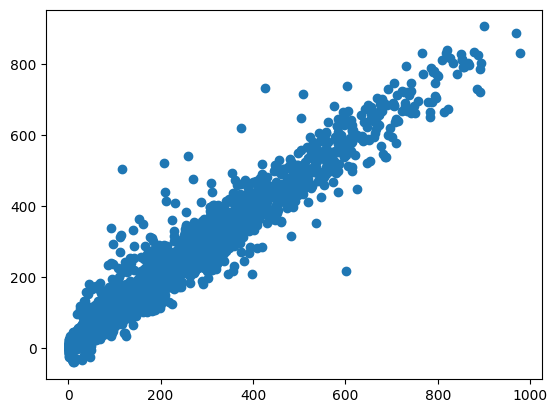

In [175]:
plt.scatter(y_test, y_pred)

In [176]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

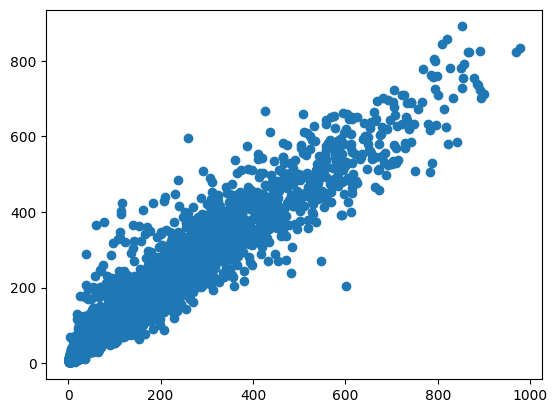

In [177]:
plt.scatter(y_test, y_pred)

In [178]:
# for i, j in zip(y_test, y_pred):
#     print(i, '--->', j)

In [179]:
# from sklearn import set_config
# set_config(display='diagram')

In [180]:
# pipe.fit(X_train, y_train)

In [181]:
# y_pred = pipe.predict(X_test)

In [182]:
# print("R2 Score:", r2_score(y_test, y_pred))
# print("MAE:", mean_absolute_error(y_test, y_pred))
# print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

In [183]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#      'trf3__n_estimators': [100, 200, 300],
#     'trf3__max_depth': [None, 10, 20],
#     'trf3__min_samples_split': [2, 5, 10],
#     'trf3__max_features': ['sqrt', 'log2']
# }

# grid = GridSearchCV(pipe, param_grid, cv=5, error_score='raise')
# grid.fit(X_train, y_train)

In [184]:
# print(grid.best_params_)

In [185]:
# y_pred_after = grid.predict(X_test)

In [186]:
# print(f'''{'-'*10} Randomforest {'-'*10}''')
# print("R2 Score:", r2_score(y_test, y_pred))
# print("MAE:", mean_absolute_error(y_test, y_pred))
# print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# print(f'''{'-'*10} after GridSearch {'-'*10}''')
# print("R2 Score:", r2_score(y_test, y_pred_after))
# print("MAE:", mean_absolute_error(y_test, y_pred_after))
# print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_after)))


In [187]:
# for p,s in zip(grid.cv_results_['params'],grid.cv_results_['mean_test_score']):
#     print(p,s)
# X_train.isnull().sum().sum()
# X_test.isnull().sum().sum()
# X_train.dtypes

# pipe.set_params(trf3__n_estimators=100, trf3__max_features='sqrt')
# pipe.fit(X_train, y_train)

In [188]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Use the best estimator from GridSearchCV
# best_pipe = grid.best_estimator_

# # Step 1: Get feature names from trf1 (ColumnTransformer)
# # OneHotEncoder produces multiple output columns
# ohe_feature_names = best_pipe.named_steps['trf1'].transformers_[0][1].get_feature_names_out()

# # Combine all transformed features: OneHotEncoder + OrdinalEncoder + numerical passthrough
# # trf1 has: [('ohe', OneHotEncoder, [4,6,7]), ('ord', OrdinalEncoder, [0,2,5])]
# # remainder='passthrough' applies to [1,3,8,9,10,11]

# # Get all feature names in the correct order
# # Extract raw feature names
# raw_feature_names = X_train.columns.tolist()

# # Order in ColumnTransformer:
# # OneHot: 4,6,7 -> ['holiday', 'weathersit', 'workingday']
# # Ordinal: 0,2,5 -> ['season', 'mnth', 'weekday']
# # Passthrough: 1,3,8,9,10,11 -> ['yr', 'hr', 'temp', 'atemp', 'hum', 'windspeed']

# ordinal_cols = ['season', 'mnth', 'weekday']
# passthrough_cols = ['yr', 'hr', 'temp', 'atemp', 'hum', 'windspeed']

# # Combine all feature names
# feature_names = list(ohe_feature_names) + ordinal_cols + passthrough_cols

# # Step 2: Get feature importances from the best model
# importances = best_pipe.named_steps['trf3'].feature_importances_

# # Step 3: Plot feature importances
# feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
# plt.figure(figsize=(12, 6))
# feat_imp.plot(kind='bar')
# plt.title('Feature Importance (Random Forest)')
# plt.tight_layout()
# plt.show()
